In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")
SEED = 7355608

In [3]:
data = pd.read_csv("bikes.csv")
data.head()

,count,hour,temperature,humidity,windspeed
0,16,0,0.24,0.81,0.0000
1,3,5,0.16,0.47,0.2836
2,115,9,0.22,0.37,0.3284
3,73,13,0.20,0.37,0.2836
4,82,15,0.22,0.35,0.3582


In [4]:
data[["hour", "temperature", "humidity", "windspeed"]].describe()

,hour,temperature,humidity,windspeed
count,348.000000,348.000000,348.000000,348.000000
mean,11.511494,0.498966,0.628822,0.179539
std,6.925073,0.194320,0.189069,0.115922
min,0.000000,0.060000,0.180000,0.000000
25%,5.750000,0.340000,0.500000,0.104500
50%,12.000000,0.500000,0.635000,0.164200
75%,17.000000,0.660000,0.780000,0.253700
max,23.000000,0.920000,1.000000,0.522400


In [5]:
num_knots = 6
knots = np.linspace(0, 23, num_knots + 2)[1:-1]
model_spline = bmb.Model(
    "count ~ bs(hour, degree=3, knots=knots)", data, family="negativebinomial"
)
idata_spline = model_spline.fit(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [count_alpha, Intercept, bs(hour, degree=3, knots=knots)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [6]:
hour = np.linspace(0, 23, num=200)
new_data = pd.DataFrame({"hour": hour})
model_spline.predict(idata_spline, data=new_data, kind="pps")

/home/pablo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


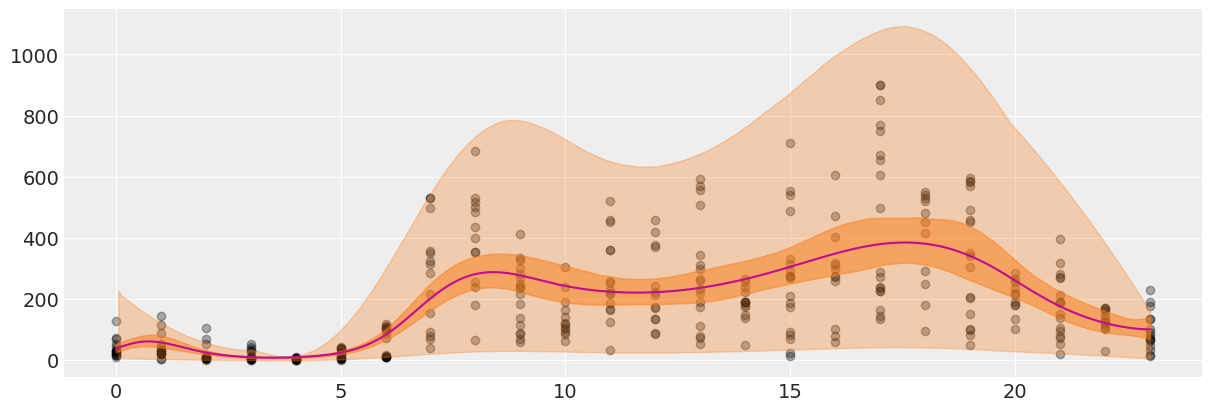

In [7]:
q = [0.025, 0.975]
dims = ("chain", "draw")

mean = idata_spline.posterior["count_mean"].mean(dims).to_numpy()
mean_interval = idata_spline.posterior["count_mean"].quantile(q, dims).to_numpy()
y_interval = idata_spline.posterior_predictive["count"].quantile(q, dims).to_numpy()

fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(data["hour"], data["count"], alpha=0.3, color="k")
ax.plot(hour, mean, color="C3")
ax.fill_between(hour, mean_interval[0], mean_interval[1], alpha=0.5, color="C1")
az.plot_hdi(hour, y_interval, fill_kwargs={"color": "C1", "alpha": 0.3}, ax=ax);

In [9]:
num_knots = 6
knots = np.linspace(0, 23, num_knots + 2)[1:-1]
knots2 = np.linspace(0.06, 0.92, num_knots + 2)[1:-1]
knots3 = np.linspace(0.18, 1.0, num_knots + 2)[1:-1]
knots4 = np.linspace(0, 0.52, num_knots + 2)[1:-1]
model_spline_4v = bmb.Model(
    """count ~ bs(hour, degree=3, knots=knots)
                                     + bs(temperature, degree=3, knots=knots2)
                                     + bs(humidity, degree=3, knots=knots3)
                                     + bs(windspeed, degree=3, knots=knots4)""",
    data,
    family="negativebinomial",
)
idata_spline_4v = model_spline_4v.fit(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [count_alpha, Intercept, bs(hour, degree=3, knots=knots), bs(temperature, degree=3, knots=knots2), bs(humidity, degree=3, knots=knots3), bs(windspeed, degree=3, knots=knots4)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 123 seconds.
